In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [13]:
df = pd.read_csv("/Users/hanzichun/desktop/Optiver-07/Data/individual_book_train/stock_0.csv")

In [14]:
df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
df['spread'] = df['ask_price1'] - df['bid_price1']
df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'] + 1e-8)
df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'] + 1e-8)
df['log_wap_return'] = np.log(df['wap'] / df['wap'].shift(1)).fillna(0)


df['log_return'] = np.log(df['mid_price'] / df['mid_price'].shift(1)).fillna(0)
df['realized_volatility'] = (
    df['log_return']
    .rolling(window=30, min_periods=1)
    .apply(lambda x: np.sqrt(np.sum(x**2)))
)

df['rv_future'] = df['realized_volatility'].shift(-30)

df = df.dropna()

feature_cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',
                'mid_price', 'spread', 'imbalance', 'wap', 'log_wap_return']

target_col = 'rv_future'

# Scaling
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_all = x_scaler.fit_transform(df[feature_cols])
y_all = y_scaler.fit_transform(df[[target_col]]).flatten()

# Rolling sequences
SEQ_LEN = 30

def build_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len].flatten())
        y_seq.append(y[i + seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = build_sequences(X_all, y_all, SEQ_LEN)

split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

mlp = MLPRegressor(
    hidden_layer_sizes=(64,),
    activation='relu',
    solver='adam',
    learning_rate_init=1e-4,
    alpha=1e-4,
    max_iter=500,
    shuffle=False,
    random_state=42
)

mlp.fit(X_train, y_train)

# Predictions
pred_scaled = mlp.predict(X_test)
actual_scaled = y_test

# Inverse Transform
predictions = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actuals = y_scaler.inverse_transform(actual_scaled.reshape(-1, 1)).flatten()

# Evaluation
rmse = root_mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual, eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(actuals, predictions)

print(f"Out-of-sample RMSE: {rmse:.6f}")
print(f"R² score: {r2:.6f}")
print(f"QLIKE: {ql:.6f}")

Out-of-sample RMSE: 0.001826
R² score: 0.065804
QLIKE: 12.972003


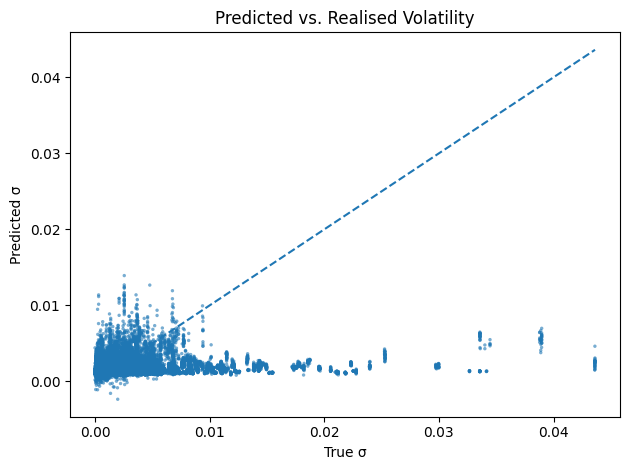

In [15]:
plt.figure()
plt.scatter(actuals, predictions, s=6, alpha=0.6, edgecolor="none")
max_val = max(np.max(actuals), np.max(predictions))
plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.title("Predicted vs. Realised Volatility")
plt.xlabel("True σ")
plt.ylabel("Predicted σ")
plt.tight_layout()
plt.show()

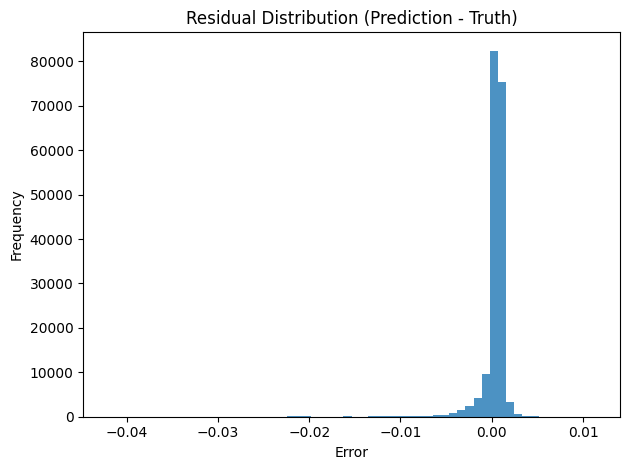

In [16]:
residuals = predictions - actuals
plt.figure()
plt.hist(residuals, bins=60, alpha=0.8)
plt.title("Residual Distribution (Prediction - Truth)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

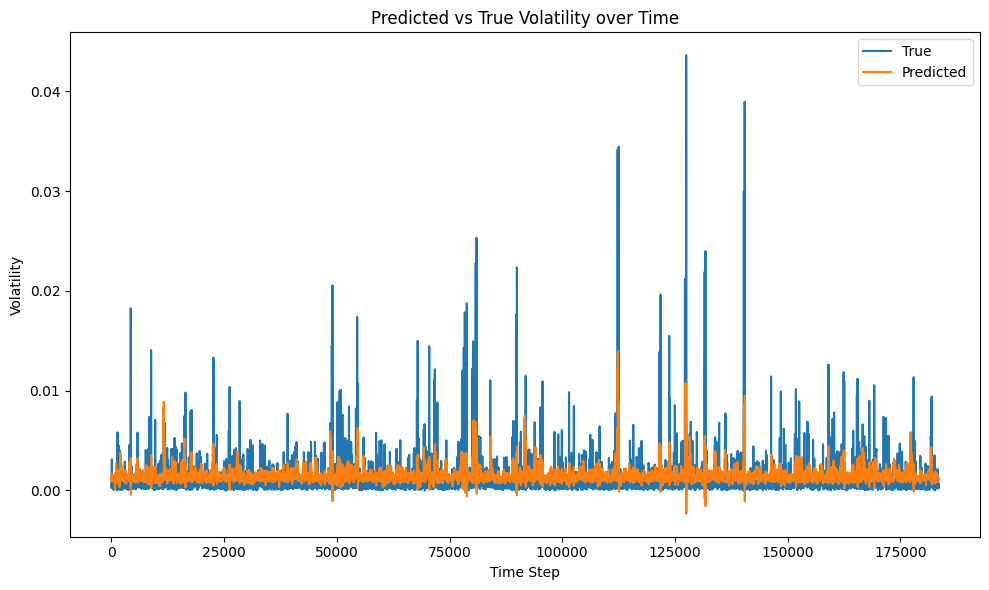

In [17]:
plt.figure(figsize=(10,6))
plt.plot(actuals, label='True')
plt.plot(predictions, label='Predicted')
plt.title('Predicted vs True Volatility over Time')
plt.xlabel('Time Step')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()